#PARTIE II : MODELISATION ET CLUSTERING 

Dans la première partie nous avons cherché à montrer à partr d'études de cas concret qu'il semble être une mauvaise idée de simplement se contenter d'observer certaines
variables en vue d'inférer de l'état de santé de la population. Dans cette partie nous chercherons à dépasser les conclusions de la première partie avec de la modélisation plus poussée
et à comprendre pourquoi tel ets le cas.
Il s'agira dans une démarche opposée d'essayer de comprendre comment seulment certaines variables précises semblen avoir une influence détreminante et comment les départements
reflètent finalement esseniellement la répartition de ces variables ci. Dès lors, nous allons chercher à mettre en lumière quels sont ces variables, leur poids 
réel et voir comment cela influence le developpement de pathologie au sein des différents départements. (à modifier au fur et à mesure). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
!pip install factor-analyzer
from factor_analyzer import FactorAnalyzer
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 64.0 MB/s eta 0:00:00
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.0-py2.py3-none-any.whl size=42486 sha256=d62d1d65c39f5129c18baefc0be0bb30f465d39b3d74cd18139b90b8871c234b
  Stored in directory: /home/onyxia/.cache/pip/wheels/74/a2/6c/26fb1addf1ce6c60a8cef8397f2999f0a1e6e2fcddc8abf33e
Successfully built factor-analyzer


In [3]:
#on reprend data_dummies un version corrigé des la base effectifs de base, auquel on ajouté les variables catgéorielles des pathologies de niveau 1 
df = pd.read_csv('data_dummies.csv')
df

,Unnamed: 0,ind,annee,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,dept,...,indicatrice__Maladies cardio-neurovasculaires,indicatrice__Maladies du foie ou du pancréas (hors mucoviscidose),indicatrice__Maladies inflammatoires ou rares ou VIH ou SIDA,indicatrice__Maladies neurologiques ou dégénératives,indicatrice__Maladies psychiatriques,indicatrice__Maladies respiratoires chroniques (hors mucoviscidose),indicatrice__Maternité (avec ou sans pathologies),indicatrice__Séjours en hospitalisation complète pour prise en charge de la Covid-19,indicatrice__Traitements du risque vasculaire (hors pathologies),indicatrice__Traitements psychotropes (hors pathologies)
0,0,0,2020,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,1.0,971,...,0,0,0,0,0,0,0,0,1,0
1,1,1,2020,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,3.0,973,...,0,0,0,0,0,0,0,0,1,0
2,2,2,2020,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,4.0,999,...,0,0,0,0,0,0,0,0,1,0
3,3,3,2020,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,6.0,999,...,0,0,0,0,0,0,0,0,1,0
4,4,4,2020,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,11.0,75,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872585,2008181,3975204,2020,Cancer colorectal,Cancer colorectal sous surveillance,top_CanColo_sur,40-44,1.0,76.0,999,...,0,0,0,0,0,0,0,0,0,0
1872586,2008182,3975208,2020,Cancer colorectal,Cancer colorectal sous surveillance,top_CanColo_sur,40-44,1.0,84.0,38,...,0,0,0,0,0,0,0,0,0,0
1872587,2008183,3975210,2020,Cancer colorectal,Cancer colorectal sous surveillance,top_CanColo_sur,40-44,1.0,84.0,69,...,0,0,0,0,0,0,0,0,0,0
1872588,2008184,3975212,2020,Cancer colorectal,Cancer colorectal sous surveillance,top_CanColo_sur,40-44,1.0,84.0,74,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Regression logistique de la maladie sur l'âge.
Après avoir travaillé un certain temps sur ce projet et réaliser quelque test,  il est apparut  assez évident que l'âge jouait un rôle
déterminant pour la contraction de maladies. Il convenait de de déterminer "à quel point". C'est pourquoi nous avons mené une régression logistique sur la question. 
Après plusieurs tentatives, c'est avec une méthode de ré échantillonnage et de changements de poids que nous sommes parvenus au résultat le plus précis. 
En effet, les malades atteints de cancer étant en minorité dans la population, sans modification de leur poids ou échantillonnage différent, il aurait été naturel de classer tous les individus comme bien portants pour minimiser le risque d'erreur.

In [4]:
df_regression = df[['indicatrice__Cancers', 'classe_age']].dropna()


X = df_regression[['classe_age']]
y = df_regression['indicatrice__Cancers']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#re echantillonnage 
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

#On change les poids
model = LogisticRegression(class_weight='balanced')
model.fit(X_resampled, y_resampled)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions, zero_division=1)

coefficients = model.coef_[0]
intercept = model.intercept_[0]

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

Accuracy: 0.5515462541186271
Confusion Matrix:
[[176295 147077]
 [ 20877  30269]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68    323372
           1       0.17      0.59      0.26     51146

    accuracy                           0.55    374518
   macro avg       0.53      0.57      0.47    374518
weighted avg       0.80      0.55      0.62    374518

Coefficients: [0.01507674]
Intercept: -0.8885707756839986


On remarque que pour chaque classe d'âge franchie, les chances de contracter un cancer augmentent de 0.015, ce qui est un coefficient relativement important comparé aux résultats des autres régression.

/opt/mamba/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


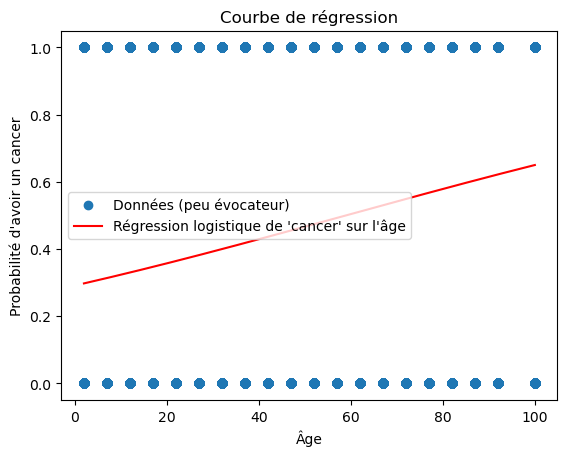

In [5]:

X_values = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
probabilities = model.predict_proba(X_values)[:, 1]

plt.scatter(X, y, label='Données (peu évocateur)')
plt.plot(X_values, probabilities, color='red', label="Régression logistique de 'cancer' sur l'âge")
plt.xlabel('Âge')
plt.ylabel("Probabilité d'avoir un cancer")
plt.title('Courbe de régression')
plt.legend()
plt.show()

In [ ]:
Ainsi, ce que nous révèle cette analyse, c'est bien le rôle prépondérant de l'âge dans le développement de pathologies. Un fois cette conclusion tirée, nous
allons pouvoir évaluer dans quelle mesure [...]

# CLUSTERING/ACP
Le but de cette partie est d'essayer de dresser des catégories de départements similaires. On garde plusieurs variables assez différentes, que ce soit les maladies ou les données liées à la pollution pour essayer de trouver les "tendances lourdes" ou des mécanismes qui pourraient sous-tendre la répartition des maladies en france. 

On inclut autant de variables pour essayer de trouver des catégories qui soient "vraiment" homogènes entre elles et qui ne soient pas trop influencées par des effets de structure (par exemple, inclure la classe d'âge et la taille de la population pour ne pas avoir un biais de variable omise et que Paris, les Bouches du Rhône ou le département du Nord soit un outlier du fait du nombre de malades, ou que les départements ayant une population plus âgée ne soit pas surreprésentés à tort du fait de leur nombre de maladies qui serait plus important).

In [6]:
df_cluster = pd.read_csv('base_modelisation.csv')
df_cluster = df_cluster.drop(['Unnamed: 0', 'dept', 
                              'indicatrice_Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)'], axis = 1)
df_cluster = df_cluster.set_index('dep', drop = True)


FileNotFoundError: [Errno 2] No such file or directory: 'base_modelisation.csv'

In [ ]:
#On fait l'acp et on standardise nos variables
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_cluster)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df_cluster.columns)
fig, ax = plt.subplots(figsize=(8, 8))

#Cercle de correlation
circle = plt.Circle((0, 0), 1, fill=False, edgecolor='b', linestyle='dashed')
ax.add_patch(circle)
for i, var in enumerate(loading_matrix.index):
    ax.arrow(0, 0, loading_matrix.loc[var, 'PC1'], loading_matrix.loc[var, 'PC2'],
             color='r', alpha=0.7, linewidth=0.5, head_width=0.02, head_length=0.02)
    ax.text(loading_matrix.loc[var, 'PC1'] * 1.15, loading_matrix.loc[var, 'PC2'] * 1.15, var,
            color='b', ha='center', va='center')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal', 'box')
ax.set_title('Cercle de corrélations')

plt.show()

On remarque que la classe d'âge se dénote quelque peu du reste des variables liées aux maladies, elle ne contribue qu'à la première composante principale. 
Par ailleurs, on remarque que beaucoup de variables sont très liées entre elles, c'est pourquoi on effectue une ACP avec la méthode de rotation 'Promax' pour que ce soit plus interprétable et essayer de distinguer s'il n'y a pas d'autres facteurs qui peuvent être également importants.

In [ ]:
#Memes operations que precedemment mais avec la methode de rotation promax
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_cluster)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
fa = FactorAnalyzer(rotation='promax', n_factors=2)
fa.fit(df_cluster)
rotated_loadings = fa.loadings_
fig, ax = plt.subplots(figsize=(8, 8))

# Cercle de correlations
circle = plt.Circle((0, 0), 1, fill=False, edgecolor='b', linestyle='dashed')
ax.add_patch(circle)
for i, var in enumerate(df_cluster.columns):
    ax.arrow(0, 0, rotated_loadings[i, 0], rotated_loadings[i, 1],
             color='r', alpha=0.7, linewidth=0.5, head_width=0.02, head_length=0.02)
    ax.text(rotated_loadings[i, 0] * 1.15, rotated_loadings[i, 1] * 1.15, var,
            color='b', ha='center', va='center')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal', 'box')
ax.set_title('Cercle de corrélations en ayant appliqué la méthode de rotation Promax')

plt.show()

On remarque que les variables sont un (tout) petit peu moins groupées. Mais c'est pourquoi, afin de trouver les variables les plus intéressantes, on garde celles qui contribuent le plus aux différentes composantes principales et on laisse de côté celles qui sont déjà très corrélées aux variables et qui, par ailleurs, contribuent moins aux composantes principales.

In [ ]:
list_to_drop = ['Energie', 'Autres transports international', 'Routier',
                'indicatrice_Traitements psychotropes (hors pathologies)',
                'indicatrice_Maladies cardio-neurovasculaires',
                'indicatrice_Maladies psychiatriques', 'indicatrice_Diabète','indicatrice_Séjours en hospitalisation complète pour prise en charge de la Covid-19',
                'indicatrice_Traitements du risque vasculaire (hors pathologies)']
                
                

In [ ]:
df_cluster_reduit = df_cluster.drop(list_to_drop, axis = 1)


In [ ]:
#on refait exactement les memes commandes que precemment mais avec un jeu de donnees reduit pour essayer
#d ameliorer notre modele
pca = PCA(n_components=2)
pca_result_bis = pca.fit_transform(df_cluster_reduit)
pca_df_reduit = pd.DataFrame(data=pca_result_bis, columns=['PC1', 'PC2'])
fa = FactorAnalyzer(rotation='promax', n_factors=2)
fa.fit(df_cluster_reduit)
rotated_loadings = fa.loadings_
fig, ax = plt.subplots(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, fill=False, edgecolor='b', linestyle='dashed')
ax.add_patch(circle)
for i, var in enumerate(df_cluster_reduit.columns):
    ax.arrow(0, 0, rotated_loadings[i, 0], rotated_loadings[i, 1],
             color='r', alpha=0.7, linewidth=0.5, head_width=0.02, head_length=0.02)
    ax.text(rotated_loadings[i, 0] * 1.15, rotated_loadings[i, 1] * 1.15, var,
            color='b', ha='center', va='center')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal', 'box')
ax.set_title('Cercle de corrélation avec moins de variables, et rotation Promax')

plt.show()

On remarque que mis à part le titre et une partie des variables assez liées en pollution, le cercle de corrélations est plus lisible. 
C'est pourquoi on va mener un clustering sur ces composantes principales.

### Clustering k-moyennes

In [ ]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_df_reduit)
    wcss.append(kmeans.inertia_)

#On regarde la methode du coude
plt.plot(range(1, 11), wcss)
plt.title('Heuristique du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des carrés des distances intra cluster')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_cluster_reduit['Cluster'] = kmeans.fit_predict(pca_df)

In [ ]:
df_cluster_reduit.loc[df_cluster_reduit['Cluster'] == 4]

In [ ]:
plt.scatter(pca_df_reduit['PC1'], pca_df_reduit['PC2'], c=df_cluster_reduit['Cluster'], cmap='viridis')
plt.title('Clusters faits avec les composantes principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Les départements : Bouches-du-Rhône, Nord, Rhône, Seine-Maritime et la Seine-et-Marne semblent se détacher pas les deux composantes principales comparé au reste des départements. Ce sont des départements très peuplés avec des niveaux de pollution élevés du fait de la densité de la population et du degré d'urbanisme dans certains cas. On peut donc commencer à déceler un lien, dans certains cas extrêmes entre la pollution et le taux de maladies. Cependant, dans la majorité des autres cas, où la pollution est bien moindre, il est plus difficile de pouvoir quantifier l'effet de la pollution sur la santé. 

Il semblerait qu'il faille donc une quantité de pollution très importante pour que des effets commencent à être perceptibles à l'échelle du département. Il n'y aurait pas de relation linéaire mais davantage un effet de seuil.

Pour permettre de mieux voir ces résultats et de constater l'appartenance de chaque département à un certain cluster, nous faisons ce graphique 'interactif'.
Le clustering se base toujours sur l'ACP réduite avec la rotation promax. 
On continue de garder 5 clusters car c'est le nombre de clusters que nous avions retenus pour les cartes, et par ailleurs, la méthode du coude semble indiquer que c'est un bon résultat.

In [ ]:
df_cluster_reduit_reset = df_cluster_reduit.reset_index()

#ACP
pca = PCA(n_components=2)
pca_result_bis = pca.fit_transform(df_cluster_reduit_reset.drop(columns=['dep']))  
pca_df_reduit = pd.DataFrame(data=pca_result_bis, columns=['PC1', 'PC2'])
fa = FactorAnalyzer(rotation='promax', n_factors=2)
fa.fit(df_cluster_reduit_reset.drop(columns=['dep'])) 
rotated_loadings = fa.loadings_

#Clustering
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_df_reduit)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Heuristique du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des carrés des distances intra-clusters')
plt.show()
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_cluster_reduit_reset['Cluster'] = kmeans.fit_predict(pca_df_reduit)
df_combined = pd.concat([df_cluster_reduit_reset[['dep', 'Cluster']], pca_df_reduit], axis=1)

# On utilise plotly pour que ce soit interactif
fig = px.scatter(df_combined, x='PC1', y='PC2', color='Cluster',
                 title='Clusters intéractifs', labels={'Cluster': 'Cluster'},
                 color_continuous_scale='viridis', hover_name='dep')

fig.show()

# ACP et Clustering sur la tranche des 30-60 ans 
Comme nous avons remarqué que l'âge avait une place prépondérante dans la détermination de la maladie, nous avons cherché sinon à éliminer l'effet de l'âge, du moins essayer de le minorer pour voir si la pollution avait en effet un impact sur la santé. 
La classe d'âge choisie est certes hétéroclite mais nous pensons que cela pourrait être plus évocateur. 

In [ ]:
df_cluster_30_60 = pd.read_csv('base_modelisation_30_60.csv')
df_cluster_30_60 = df_cluster_30_60.drop(['Unnamed: 0', 'dept', 
                              'indicatrice_Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)'], axis = 1)
df_cluster_30_60 = df_cluster_30_60.set_index('dep', drop = True)

In [ ]:
print(df_cluster_30_60.var())

In [ ]:
#il y avait une erreur dans l acp reduite a une partie de la population
#on remarque qu'il y a des variables dont la variance est nulle
#on peut donc les supprimer comme elle n apportent pas d information pour categoriser la population

In [ ]:
df_cluster_30_60 = df_cluster_30_60.drop(['indicatrice_Autres affections de longue durée (dont 31 et 32)',
                               'indicatrice_Maladies respiratoires chroniques (hors mucoviscidose)'], axis = 1)


In [ ]:
#On refait une acp en standardisant les variables et appliquant la méthode de rotation promax
pca_30_60 = PCA(n_components=2)
pca_result_30_60 = pca_30_60.fit_transform(df_cluster_30_60)
pca_df_30_60 = pd.DataFrame(data=pca_result_30_60, columns=['Custom_PC1', 'Custom_PC2'])
explained_variance_ratio = pca_30_60.explained_variance_ratio_
fa = FactorAnalyzer(rotation='promax', n_factors=2)
fa.fit(df_cluster_30_60)
rotated_loadings = fa.loadings_
fig, ax = plt.subplots(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, fill=False, edgecolor='b', linestyle='dashed')
ax.add_patch(circle)
for i, var in enumerate(df_cluster_30_60.columns):
    ax.arrow(0, 0, rotated_loadings[i, 0], rotated_loadings[i, 1],
             color='r', alpha=0.7, linewidth=0.5, head_width=0.02, head_length=0.02)
    ax.text(rotated_loadings[i, 0] * 1.15, rotated_loadings[i, 1] * 1.15, var,
            color='b', ha='center', va='center')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal', 'box')
ax.set_title('Cercle de corrélation pour les 30-60 ans')

plt.show()
print(f"R-squared for PC1: {explained_variance_ratio[0]:.4f}")
print(f"R-squared for PC2: {explained_variance_ratio[1]:.4f}")


Le choix de la tranche d'âge de 30 à 60 ans vient du fait qu'avec nos données, la moyenne des patients atteints de cancer est de 64 ans.
Par ailleurs, comme on a pu le voir à plusieurs reprises, l'âge est un facteur décisif pour la contraction du cancer. Choisir la classe d'âge de 30 à 60 ans aurait pu mettre en lumière les cas de cancer pour les individus étant exposés à la pollution et développant ainsi un cancer "prématurément". 
On fait peut-être face à nouveau à un problème d'échelle. 

L'effet de la classe d'âge est diminué par rapport au cas où on prenait la population en entier de façon assez prévisible. Mais on remarque aussi que les variables vont moins toutes dans le même sens.

In [ ]:
#Clustering par la méthode des k-moyennes, on garde encore 5 clusters pour pouvoir faire des comparaisons,
#la composante 1 continue de faire une grande partie de la catégorisation
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_cluster_30_60['cluster'] = kmeans.fit_predict(pca_result_30_60)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result_30_60[:, 0], pca_result_30_60[:, 1], c=df_cluster_30_60['cluster'], cmap='viridis')
plt.title("Clustering à partir de l'ACP")
plt.xlabel('1ère composante principale')
plt.ylabel('2ème composante principale')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

In [ ]:
df_cluster_30_60.to_csv("df_cluster_30_60.csv")

On remarque tout de même qu'il y a un peu plus de disparités et de variations que dans le cas où on regardait la population dans son ensemble. On peut dire qu'il y a peut-être plus d'interprétations possibles dans ce cas-là qu'auparavant, et c'est ce que l'on va essayer de voir dans les régressions logistiques. 

# Regression logistique bis, cas multivarié avec plusieurs facteurs explicatifs, et en prenant en compte la pollution
On procède cette fois à l'échelle individuelle pour essayer de mettre plus en avant l'effet de la pollution non pas à l'échelle agrégée mais de chaque patient.

In [ ]:
data_reg = pd.read_csv("data_reg.csv")

In [ ]:
data_reg = data_reg.drop(['Unnamed: 0', 'ind', 'dept'], axis = 1)

In [ ]:
data_reg['classe_age'].unique()

In [ ]:
data_reg = data_reg[data_reg['classe_age'].isin([62,67,72])]
#ligne du dessus a enlever ou modifier  si on veut etudier une population en particulier ou la population en entier, 
#pour ceux entre 60 et 75 ans, les resultas restent similaires, et donnent une place 
#relativement faible a la pollution, la seule qui ait un effet un peu moindre que les autres est
#Industrie hors energie, le odd ratio est autour de 1.012/1.013
#c est donc assez peu

# Régression cancer bis
### Sorte d'étude de cas du cancer parmi la population la plus touchée cette fois, pour essayer de mettre en évidence un possible effet de la pollution
On sélectionne cette fois une tranche d'âge plus réduite parce que ne comportant que les gens âgés de 60 à 75 ans. On se place donc dans le cadre précis pour étudier là où il y a le plus de cancers. 
Il va sans dire que notre approche peut être problématique en cela que l'on cherche à montrer qu'il y a une corrélation mais cela nous semblait intéressant de voir comment il était possible de quantifier les effets de la pollution.

In [ ]:
data_reg_cancer = data_reg.drop(['indicatrice_Maladies cardio-neurovasculaires',
                                'indicatrice_Maladies respiratoires chroniques (hors mucoviscidose)',
                                'classe_age'], axis = 1)

In [ ]:
#ACP "classique", en standardisant les donnees au prealable 

X = data_reg_cancer.drop('indicatrice_Cancers', axis=1)
y = data_reg_cancer['indicatrice_Cancers']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
r_squared = sum(explained_variance_ratio)
print(f"R carré pour les deux principales composantes: {r_squared:.4f}")
coefficients = pca.components_.T * np.sqrt(pca.explained_variance_)
fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("1ère composante principale")
ax.set_ylabel("2ème composante principale")
ax.set_aspect('equal')

ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
for i, (comp, var) in enumerate(zip(coefficients, pca.explained_variance_)):
    circle = plt.Circle((0, 0), 1, edgecolor='r', facecolor='none')
    ax.add_patch(circle)
    ax.arrow(0, 0, comp[0], comp[1], color='b', width=0.01, head_width=0.1)
    ax.text(comp[0], comp[1], X.columns[i], color='b', ha='right', va='bottom')
plt.show()

#Clustering avec la methode des k-moyennes
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
data_reg_cancer['cluster'] = clusters
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title("Clusters avec les composantes de l'ACP")
plt.xlabel('1ère composante principale')
plt.ylabel('2ème composante principale')

cluster_centers_pca = pca.transform(kmeans.cluster_centers_)

#on rajoute ces lignes parce qu il y a eu des problemes d affichages a repetition 
#par rapport aux codes precedents donc c est le seul changement notable

legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(i / n_clusters), markersize=10) for i in range(n_clusters)]

for i, label in enumerate(legend_elements):
    plt.annotate(legend_labels[i], cluster_centers_pca[i], textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.show()


data_reg_cancer = pd.get_dummies(data_reg_cancer, columns=['cluster'], prefix = 'ind_cluster', dtype='int')

In [ ]:
X = data_reg_cancer.drop('indicatrice_Cancers', axis=1)
y = data_reg_cancer['indicatrice_Cancers']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#on cree des populations de controles et d autres de test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


logreg_model = LogisticRegression(class_weight={0: 1, 1: 5}) #Parce qu on s intersse aux cas ou la variable 
#est egale a un et si on ne balance pas comme ca, comme les 0 sont majoritaires, la regression classera tout le monde en 0


logreg_model.fit(X_train, y_train)


y_pred = logreg_model.predict(X_test)


print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

print("\nRésultats:")
print(classification_report(y_test, y_pred))



In [ ]:
#on effectue maintenant une regression logistique en changeant les faisant du re echantillonnage
#n ameliore pas enormement les resultats

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
logreg_model_resampled = LogisticRegression()
logreg_model_resampled.fit(X_resampled, y_resampled)
y_pred_resampled = logreg_model_resampled.predict(X_test)

print("\nMatrice de confusion avec du ré echantillonnage:")
print(confusion_matrix(y_test, y_pred_resampled))

print("\nRésultats:")
print(classification_report(y_test, y_pred_resampled))


In [ ]:
#on regarde les coefficients des differentes variables
#on a inclus l appartenance a certains clusters
coefficients = logreg_model_resampled.coef_[0]
intercept = logreg_model_resampled.intercept_[0]

coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': coefficients})

coefficients_df['Odds Ratio'] = coefficients_df['Coefficient'].apply(lambda x: round(np.exp(x), 4))
coefficients_df['Effet'] = coefficients_df['Odds Ratio'].apply(lambda x: f"Augmente de {x} " if x > 1 else f"Baisse de {round(1/x, 4)}")

print(coefficients_df)

Clusters 2 et 3 semblent avoir un effet sur les cas, à nouveau assez petit mais tout de même.
Il peut y avoir une petite correlation, le cluster 3 est celui avec le plus de pollution par les deux composantes principales. 

Le cluster 2 quant à lui a assez peu de CO2 biomasse hors-total mais a une pollution agricole plus importante.
Par ailleurs, le nom des clusters changeant à chaque fois que l'on fait tourner le code, il se peut qu'ils ne correspondent plus au bon numéro. 

Néanmoins, il apparaît que le cluster qui causerait une augmentation de .02 soit l'une des variables avec le plus grand coefficient que l'on ait pu trouver tout au long de nos analyses. 
Il semblerait donc qu'il puisse y avoir une corrélation ici plus importante qu'ailleurs mais les résultats étant tout de même assez peu évocateurs et notre connaissance des régressions logistiques étant moins développée que celle sur les régressions linéaires, nous ne voulons pas non plus considérer ce résultat comme la réponse à tous nos problèmes. 

De plus, nous avons fait cette régression pour montrer spéficiquement l'effet de la pollution sur la santé et nous sommes placés dans le cas le plus favorables à ce qu'il y ait des effets plus "amplifiés". On peut donc avancer qu'il semble avoir une corrélation mais ce n'est pas un résultat qui permettrait d'affirmer ou de donner clairement une quantification de l'effet de la pollution sur la santé.

In [ ]:
#on cree deux nouveaux data frames pour pouvoir faire des regressions sur les variables 
#qui nous interessent
data_reg_neuro = data_reg.drop(['indicatrice_Cancers',
                                'indicatrice_Maladies respiratoires chroniques (hors mucoviscidose)'], axis = 1)

data_reg_resp =  data_reg.drop(['indicatrice_Cancers',
                                'indicatrice_Maladies cardio-neurovasculaires'], axis = 1)

### Regression maladies respiratoires

In [ ]:
#Regression
X = data_reg_resp.drop('indicatrice_Maladies respiratoires chroniques (hors mucoviscidose)', axis=1)
y = data_reg_resp['indicatrice_Maladies respiratoires chroniques (hors mucoviscidose)']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
logreg_model = LogisticRegression(class_weight='balanced')
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)


print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

print("\nRésultat:")
print(classification_report(y_test, y_pred))

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
logreg_model_resampled = LogisticRegression()
logreg_model_resampled.fit(X_resampled, y_resampled)
y_pred_resampled = logreg_model_resampled.predict(X_test)

print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred_resampled))

print("\nResultat:")
print(classification_report(y_test, y_pred_resampled))


In [ ]:
coefficients = logreg_model_resampled.coef_[0]
intercept = logreg_model_resampled.intercept_[0]


coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': coefficients})


coefficients_df['Odds Ratio'] = coefficients_df['Coefficient'].apply(lambda x: round(np.exp(x), 4))
coefficients_df['Effet'] = coefficients_df['Odds Ratio'].apply(lambda x: f"Augmente de{x}" if x > 1 else f"Baisse de{round(1/x, 4)} ")

print(coefficients_df)

### Régression maladies neurologiques et cardiaques

In [ ]:
X = data_reg_neuro.drop('indicatrice_Maladies cardio-neurovasculaires', axis=1)
y = data_reg_neuro['indicatrice_Maladies cardio-neurovasculaires']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
logreg_model = LogisticRegression(class_weight='balanced')
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)

print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

print("\nRésultats:")
print(classification_report(y_test, y_pred))


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
logreg_model_resampled = LogisticRegression()
logreg_model_resampled.fit(X_resampled, y_resampled)
y_pred_resampled = logreg_model_resampled.predict(X_test)

print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred_resampled))

print("\nRésultats:")
print(classification_report(y_test, y_pred_resampled))

In [ ]:
coefficients = logreg_model_resampled.coef_[0]
intercept = logreg_model_resampled.intercept_[0]


coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': coefficients})

coefficients_df['Odds Ratio'] = coefficients_df['Coefficient'].apply(lambda x: round(np.exp(x), 4))
coefficients_df['Effet'] = coefficients_df['Odds Ratio'].apply(lambda x: f"Augmente de {x} " if x > 1 else f"Baisse de {round(1/x, 4)}")

print(coefficients_df)

On remarque dans les deux dernière régressions que l'on a faites que les résultats sont moins parlants. 
Nous n'avons certes pas choisi les âges de sorte à ce que la population soit la plus encline à être malade mais cela permet aussi de remettre en perspective le résultat que nous avons obtenu précédemment. 
Avec les données par départements, à moins de "grossir le trait" de façon conséquente, comme nous avons pu le faire pour le cas du cancer, il est difficile de percevoir des effets notables sur la santé de la population. 

In [ ]:
#CONCLUSION DE LA PARTIE II :
l'âge c'est très fort
à âge égal la pollution joue un peu 
dès qu'on s'éloigne de ca y'a trop de corrélations entres les variables
Ducoup l'état de santé du département dépend essentiellement de l'âge puis un peu de la pollution et enfin de plusieurs petit facteurs indéterminés

In [ ]:
#LIMITE DE CETTE APPROCHE
(à vérifier) en soi, on utilise pas toutes les variables possibles et inimaginables, donc on pourrait toujours envisager une variable qui elle serait très
explicative ? 

In [ ]:
#CONCLUSION DU PROJET :
On ne peut pas facilement déterminer l'état de santé des individus au sein d'un déparetement en se focalisant sur quelques variables pécises.
La seule variable qui a un pouvoir prédictif satisfaisant c'est l'âge. Donc en somme ce que nous donne l'état de santé du département c'est surtout
l'âge de la population et un petit peu son état de pollution. (excepté peut etre les cas extereme comme les dom tom mais même eux il doit y avoir
trop de varibales cachées). 

La réponse à la question est donc : non , il n'est pas pertinent de considérer le département dans le cadre d'une analyse de la santé de la population, 
excepté pour se référer à l'âge de ses résidents. 